In [20]:
# import absl
# import json
# import random
# import pandas as pd
# import tensorflow as tf
# from matplotlib.patches import Rectangle
# # from tensorflow.keras.mixed_precision import experimental as mixed_precision
# from time import time
# from math import pi
# from numba import njit
# parentDir = os.path.dirname(os.path.abspath(os.getcwd()))
# sys.path.append(os.path.join(os.getcwd(), "general_utils"))
# # import file_management
# sys.path.append(os.path.join(os.getcwd(), "Model_utils"))
# # from plotting_mine import InputActivityFigure, RasterPlot, LaminarPlot, LGN_sample_plot
# import load_sparse
# import models
# import toolkit
# import analysis_utils as utils
# from scipy.stats import f_oneway
# from scipy.optimize import curve_fit
# from scipy.stats import f as f_distribution
# import h5py
# import other_billeh_utils

In [ ]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import pickle as pkl

sns.set(style="ticks")
plt.rcParams['text.usetex'] = True

# Set style parameters for publication quality
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 12,
    'axes.linewidth': 1.2,
    'axes.labelpad': 8,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'legend.frameon': True,
    'legend.fontsize': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
})

## Loss Figures

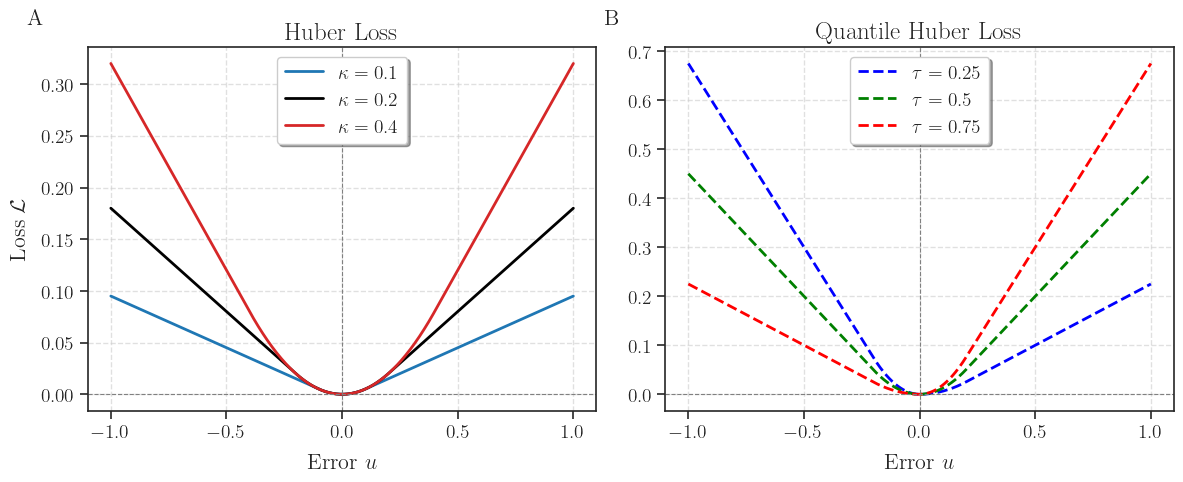

In [ ]:
# Define Huber loss function
def huber_loss(u, kappa):
    return np.where(np.abs(u) <= kappa, 0.5 * u**2, kappa * (np.abs(u) - 0.5 * kappa))

# Define Quantile Huber loss function
def huber_quantile_loss(u, tau, kappa):
    huber = huber_loss(u, kappa)
    return np.abs(tau - (u < 0)) * huber / kappa

# Generate range of u values
u_values = np.linspace(-1, 1, 500)
kappa = 0.2
taus = [0.25, 0.5, 0.75]  # Example quantiles

# Define different kappa values for comparison
kappas = [0.1, 0.2, 0.4]  # Smaller, default, and larger kappa values
kappa_colors = ['#1f77b4', 'black', '#d62728']  # Blue, Black, Red

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Huber loss with varying kappa
for kappa_val, color in zip(kappas, kappa_colors):
    axes[0].plot(u_values, huber_loss(u_values, kappa_val),
                 label=rf'$\kappa={kappa_val}$', linewidth=2, color=color)

axes[0].axhline(0, color='gray', linestyle='--', linewidth=0.8)
axes[0].axvline(0, color='gray', linestyle='--', linewidth=0.8)
axes[0].set_xlabel(r'Error $u$', fontsize=16)
axes[0].set_ylabel(r'Loss $\mathcal{L}$', fontsize=16)
axes[0].set_title('Huber Loss', fontsize=18, fontweight='bold')
axes[0].legend(fontsize=14, frameon=True, shadow=True)
axes[0].grid(True, linestyle='--', alpha=0.6)
# increase ticks fontsize
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].tick_params(axis='both', which='minor', labelsize=10)
# Add panel label
axes[0].text(-0.12, 1.05, 'A', transform=axes[0].transAxes, 
         fontsize=16, fontweight='bold', va='bottom')

# Second subplot: Quantile Huber loss
colors = ['blue', 'green', 'red']
for tau, color in zip(taus, colors):
    axes[1].plot(u_values, huber_quantile_loss(u_values, tau, 0.2),  # Fixed kappa=0.2 for consistency
                 label=rf'$\tau={tau}$', linewidth=2, linestyle='dashed', color=color)

axes[1].axhline(0, color='gray', linestyle='--', linewidth=0.8)
axes[1].axvline(0, color='gray', linestyle='--', linewidth=0.8)
axes[1].set_xlabel(r'Error $u$', fontsize=16)
axes[1].set_title('Quantile Huber Loss', fontsize=18, fontweight='bold')
axes[1].legend(fontsize=14, frameon=True, shadow=True)
axes[1].grid(True, linestyle='--', alpha=0.6)
# increase ticks fontsize
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='both', which='minor', labelsize=10)
# Add panel label
axes[1].text(-0.12, 1.05, 'B', transform=axes[1].transAxes, 
         fontsize=16, fontweight='bold', va='bottom')

# Adjust layout for clarity
plt.tight_layout()
# Save figure with a different file name for versioning
fig.savefig('Paper_figures/huber_loss_comparison.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


/tmp/ipykernel_3203290/390625652.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.02, 1, 0.96])


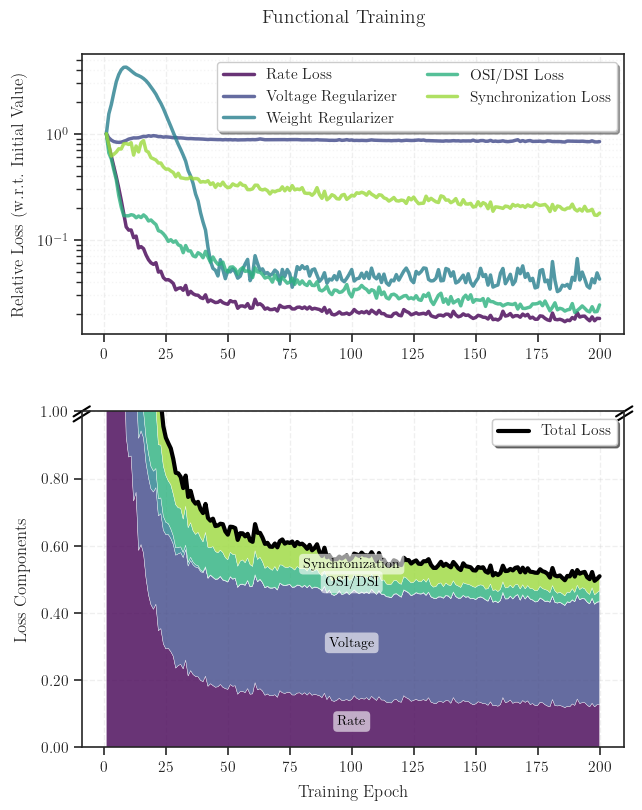

In [23]:
# Load data
path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Simulation_results/v1_100000_lm_30000/b_07x0/train_end_data.pkl'
with open(path, 'rb') as f:
    train_end_data = pkl.load(f)
train_end_data['epoch_metric_values']['val_osi_dsi_loss'] = np.array(train_end_data['epoch_metric_values']['val_osi_dsi_loss']) / 2

# Define labels and components
labels = ['val_loss', 'val_rate_loss', 'val_voltage_loss', 'val_regularizer_loss', 'val_osi_dsi_loss', 'val_sync_loss']
component_labels = [l for l in labels if l != 'val_loss']

# Create descriptive names for the labels
label_display_names = {
    'val_rate_loss': 'Rate Loss',
    'val_voltage_loss': 'Voltage Regularizer',
    'val_regularizer_loss': 'Weight Regularizer',
    'val_osi_dsi_loss': 'OSI/DSI Loss',
    'val_sync_loss': 'Synchronization Loss',
    'val_loss': 'Total Loss'
}

# Normalize loss components
normalized_data = {}
for label in labels:
    if label != 'val_loss':
        values = np.array(train_end_data['epoch_metric_values'][label])
        normalized_data[label] = values / values[0]

# Create epoch indices
epochs = np.arange(1, len(next(iter(normalized_data.values()))) + 1)

# Create figure with custom layout
fig = plt.figure(figsize=(7, 9))
gs = GridSpec(2, 1, height_ratios=[1, 1.2], hspace=0.25)

# Use a professional color palette (colorblind-friendly)
colors = plt.cm.viridis(np.linspace(0, 0.85, len(component_labels)))

# --- SUBPLOT A: NORMALIZED LOSS COMPONENTS ---
ax1 = fig.add_subplot(gs[0])

# Plot normalized loss components
for i, (label, values) in enumerate(normalized_data.items()):
    display_name = label_display_names.get(label, label)
    ax1.plot(epochs, values, label=display_name, color=colors[i], linewidth=2.5, alpha=0.8)

# Configure first subplot
ax1.set_ylabel('Relative Loss (w.r.t. Initial Value)', fontweight='bold')
ax1.set_yscale('log')
ax1.grid(True, linestyle='--', alpha=0.3, which='both')
ax1.set_axisbelow(True)  # Place grid behind data

# Add minor grid lines for log scale
ax1.grid(which='minor', linestyle=':', alpha=0.2)

# Create legend with columns outside the plot
ax1.legend(loc='upper right', ncol=2, frameon=True, fancybox=True, shadow=True)

# # Add panel label
# ax1.text(-0.12, 1.05, 'A', transform=ax1.transAxes, 
#          fontsize=16, fontweight='bold', va='bottom')

# --- SUBPLOT B: STACKED AREA CHART ---
ax2 = fig.add_subplot(gs[1])

# Get data for stacked area plot
data = np.array([train_end_data['epoch_metric_values'][label] for label in component_labels])

# Create stacked area plot
areas = ax2.stackplot(epochs, data, labels=[label_display_names[lbl] for lbl in component_labels], 
                     colors=colors, alpha=0.8, edgecolor='white', linewidth=0.3)

# Add total loss line
ax2.plot(epochs, train_end_data['epoch_metric_values']['val_loss'], 
         color='black', linewidth=3, linestyle='-', 
         label=label_display_names['val_loss'])

# Configure second subplot
ax2.set_xlabel('Training Epoch', fontweight='bold')
ax2.set_ylabel('Loss Components', fontweight='bold')
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.set_axisbelow(True)

# Format y-axis tick labels to be more readable
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Set upper limit and add break symbol
ylimit = 1  # Adjust as needed
ax2.set_ylim(0, ylimit)

# More elegant break symbol
break_size = 0.015
kwargs = dict(transform=ax2.transAxes, color='black', clip_on=False, linewidth=1.5)
ax2.plot((-break_size, +break_size), (1 - break_size, 1 + break_size), **kwargs)
ax2.plot((-break_size, +break_size), (1 - 2*break_size, 1), **kwargs)
ax2.plot((1 - break_size, 1 + break_size), (1 - break_size, 1 + break_size), **kwargs)
ax2.plot((1 - break_size, 1 + break_size), (1 - 2*break_size, 1), **kwargs)

# Add annotations for important components in the stack
middle_epoch = len(epochs) // 2
# for i, (label, area) in enumerate(zip(component_labels, areas)):
#     # Find y-coordinate in the middle of each area at the middle epoch
#     if i == 0:
#         y_pos = data[i][middle_epoch] / 2
#     else:
#         y_pos = sum(data[:i, middle_epoch]) + data[i][middle_epoch] / 2
    
#     # Only label areas that are visually significant
#     if max(data[i]) > 0.2:  # Threshold for labeling
#         ax2.annotate(label_display_names[label].split()[0],  # Use first word only
#                    xy=(middle_epoch, y_pos),
#                    ha='center', va='center',
#                    color='white' if np.mean(colors[i][:3]) < 0.6 else 'black',
#                    fontweight='bold', fontsize=10, zorder=100)

# Add annotations for important components in the stack with high z-order
for i, (label, area) in enumerate(zip(component_labels, areas)):
    # Find y-coordinate in the middle of each area at the middle epoch
    if i == 0:
        y_pos = data[i][middle_epoch] / 2
    else:
        y_pos = sum(data[:i, middle_epoch]) + data[i][middle_epoch] / 2
    
    # Only label areas that are visually significant
    if max(data[i]) > 0.2:  # Threshold for labeling
        # Add a white background to ensure text visibility
        bbox_props = dict(
            boxstyle="round,pad=0.3", 
            fc="white", 
            ec="none", 
            alpha=0.6
        )
        
        # Create annotation with high z-order and background
        ax2.annotate(
            label_display_names[label].split()[0],  # Use first word only
            xy=(middle_epoch, y_pos),
            ha='center', va='center',
            color='black',  # Use black for contrast against white background
            fontweight='bold', fontsize=10,
            bbox=bbox_props,  # Add white background
            zorder=1000  # Very high z-order to ensure it's on top
        )

# # Add panel label
# ax2.text(-0.12, 1.05, 'B', transform=ax2.transAxes, 
#          fontsize=16, fontweight='bold', va='bottom')

# Legend for total loss
total_loss_legend = ax2.legend([ax2.get_lines()[0]], [label_display_names['val_loss']], 
                             loc='upper right', frameon=True, fancybox=True, shadow=True)
ax2.add_artist(total_loss_legend)

# Add title and subtitle
fig.suptitle('Functional Training', fontsize=14, fontweight='bold', y=0.93)
# fig.text(0.5, 0.01, 'V1 Neural Network Training on MNIST Dataset', 
#          ha='center', fontsize=10, fontstyle='italic')

# Tight layout
plt.tight_layout(rect=[0, 0.02, 1, 0.96])
plt.savefig('Paper_figures/functional_training.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_3203290/2091842612.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])


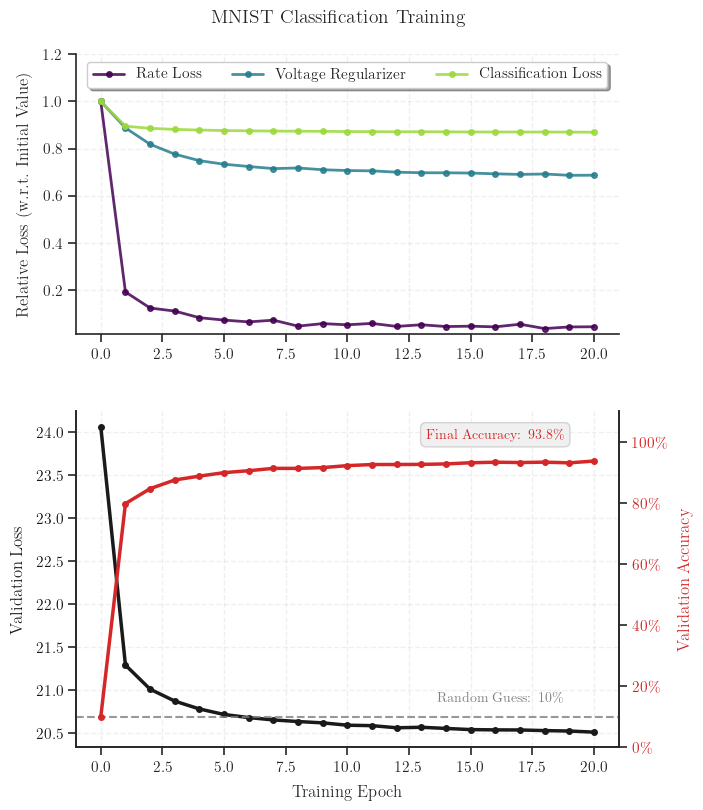

In [25]:
# Load data
path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Simulation_results/v1_100000_lm_30000/b_07x0_mnist/train_end_data.pkl'
with open(path, 'rb') as f:
    train_end_data = pkl.load(f)

# Define labels and components
labels = ['val_loss', 'val_rate_loss', 'val_voltage_loss', 'val_classification_loss']

# Fixing data by adding initial values
train_end_data['epoch_metric_values']['val_loss'] = np.array(train_end_data['epoch_metric_values']['val_loss'])
train_end_data['epoch_metric_values']['val_loss'] = np.insert(train_end_data['epoch_metric_values']['val_loss'], 0, 24.06)
train_end_data['epoch_metric_values']['val_voltage_loss'] = np.array(train_end_data['epoch_metric_values']['val_voltage_loss'])
train_end_data['epoch_metric_values']['val_voltage_loss'] = np.insert(train_end_data['epoch_metric_values']['val_voltage_loss'], 0, 0.7)
train_end_data['epoch_metric_values']['val_rate_loss'] = np.array(train_end_data['epoch_metric_values']['val_rate_loss'])
train_end_data['epoch_metric_values']['val_rate_loss'] = np.insert(train_end_data['epoch_metric_values']['val_rate_loss'], 0, 0.32)
train_end_data['epoch_metric_values']['val_classification_loss'] = np.array(train_end_data['epoch_metric_values']['val_classification_loss'])
train_end_data['epoch_metric_values']['val_classification_loss'] = np.insert(train_end_data['epoch_metric_values']['val_classification_loss'], 0, 23.03)
train_end_data['epoch_metric_values']['val_accuracy'] = np.array(train_end_data['epoch_metric_values']['val_accuracy'])
train_end_data['epoch_metric_values']['val_accuracy'] = np.insert(train_end_data['epoch_metric_values']['val_accuracy'], 0, 0.1)

# Create descriptive names for the labels
label_display_names = {
    'val_rate_loss': 'Rate Loss',
    'val_voltage_loss': 'Voltage Regularizer',
    'val_classification_loss': 'Classification Loss',
    'val_loss': 'Total Loss'
}

# Normalize each loss component
normalized_data = {}
for label in labels:
    if label != 'val_loss':
        values = np.array(train_end_data['epoch_metric_values'][label])
        normalized_data[label] = values / values[0]

# Create epoch indices
epochs = np.arange(0, len(train_end_data['epoch_metric_values']['val_loss']))

# Create figure with custom layout
fig = plt.figure(figsize=(7, 9))
gs = GridSpec(2, 1, height_ratios=[1, 1.2], hspace=0.25)

# Use a professional color palette (colorblind-friendly)
component_labels = [l for l in labels if l != 'val_loss']
colors = plt.cm.viridis(np.linspace(0, 0.85, len(component_labels)))

# --- SUBPLOT A: NORMALIZED LOSS COMPONENTS ---
ax1 = fig.add_subplot(gs[0])

# Plot normalized loss components with markers
for i, (label, values) in enumerate(normalized_data.items()):
    display_name = label_display_names.get(label, label)
    ax1.plot(epochs, values, label=display_name, color=colors[i], 
             linewidth=2, alpha=0.85, marker='o', markersize=4)

# Configure first subplot
ax1.set_ylabel('Relative Loss (w.r.t. Initial Value)', fontweight='bold')
# ax1.set_yscale('log')
ax1.grid(True, linestyle='--', alpha=0.3, which='both')
ax1.set_axisbelow(True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add minor grid lines for log scale
ax1.grid(which='minor', linestyle=':', alpha=0.2)
ax1.set_ylim(bottom=0.01, top=1.2)  # Set minimum y to avoid log scale issues

# Create legend with columns
ax1.legend(loc='upper center', ncol=3, frameon=True, fancybox=True, shadow=True)

# # Add panel label
# ax1.text(-0.12, 1.05, 'A', transform=ax1.transAxes, 
#          fontsize=16, fontweight='bold', va='bottom')

# --- SUBPLOT B: TOTAL LOSS AND ACCURACY ---
ax2 = fig.add_subplot(gs[1])

# Plot total loss
total_loss_line = ax2.plot(epochs, train_end_data['epoch_metric_values']['val_loss'], 
                          color='k', linewidth=2.5, label='Total Loss', zorder=3,
                          marker='o', markersize=4)

# Create secondary y-axis for accuracy
ax2b = ax2.twinx()
accuracy_line = ax2b.plot(epochs, train_end_data['epoch_metric_values']['val_accuracy'], 
                         color='#d62728', linewidth=2.5, label='Validation Accuracy', zorder=3,
                         marker='o', markersize=4)

# Style primary axis (total loss)
ax2.set_xlabel('Training Epoch', fontweight='bold')
ax2.set_ylabel('Validation Loss', fontweight='bold', color='k')
ax2.tick_params(axis='y', labelcolor='k')
ax2.spines['top'].set_visible(False)
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.set_axisbelow(True)

# Style secondary axis (accuracy)
ax2b.set_ylabel('Validation Accuracy', fontweight='bold', color='#d62728')
ax2b.tick_params(axis='y', labelcolor='#d62728')
ax2b.set_ylim(0, 1.05)
ax2b.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
ax2b.spines['top'].set_visible(False)

# Add random guess baseline with annotation
random_guess = 0.1  # For MNIST (10 classes)
random_line = ax2b.axhline(y=random_guess, color='#7f7f7f', linestyle='--', 
                          alpha=0.8, linewidth=1.5, zorder=1)

# Add annotation for random guess with improved styling
random_text = r'Random Guess: ' + r'10' + r'$\%$'

ax2b.text(len(epochs)*0.65, random_guess+0.05, random_text, 
         fontsize=10, color='#7f7f7f', fontweight='bold')

ax2b.set_ylim(0., 1.1)  # Set y-limits for accuracy

# # Add panel label
# ax2.text(-0.12, 1.05, 'B', transform=ax2.transAxes, 
#          fontsize=16, fontweight='bold', va='bottom')

# Add title and subtitle
fig.suptitle('MNIST Classification Training', fontsize=14, fontweight='bold', y=0.93)
# fig.text(0.5, 0.01, 'V1 Neural Network Training on MNIST Dataset', 
#          ha='center', fontsize=10, fontstyle='italic')

# Add key performance indicators as text annotations
final_accuracy = train_end_data['epoch_metric_values']['val_accuracy'][-1]
accuracy_improvement = final_accuracy - train_end_data['epoch_metric_values']['val_accuracy'][0]

# Create legend with both lines and add KPI below
lines = total_loss_line + accuracy_line
labels = ['Validation Loss', 'Validation Accuracy']

# BETTER KPI BOX LOCATION: Inside the second subplot where there's space
# Calculate a good position based on the data
min_loss = min(train_end_data['epoch_metric_values']['val_loss'])
y_position = min_loss * 1.1  # Just above the minimum loss value

# Format the KPI text for final accuracy with percent symbol
kpi_text = r'Final Accuracy: $' + f'{final_accuracy*100:.1f}' + r'\%$'

# Create an enhanced KPI box with accent color matching the accuracy curve
props = dict(facecolor='#f0f0f0', edgecolor='#d3d3d3', boxstyle='round,pad=0.4')

# Place the KPI box in upper right
ax2.text(0.9, 0.95, kpi_text, transform=ax2.transAxes,
         fontsize=10, fontweight='bold', ha='right', va='top', 
         bbox=props, color='#d62728')

# Adjust layout for professional appearance
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.subplots_adjust(hspace=0.25)

# Save the figure as a high-quality PNG file
fig.savefig('Paper_figures/mnist_classification_training.png', dpi=300, bbox_inches='tight')

plt.show()